# Semi-Supervised Learning

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pathlib
import scipy.io
import scipy.sparse
import scipy.sparse.linalg

In [2]:
home_dir = "/c/Users/thsiao3/Documents/emory_class/MATH789/hw1"
home_dir = pathlib.Path(home_dir)
os.chdir(home_dir)

import getAdjacencyMatrixKNN as adjmatrix

In [3]:
data2_path = home_dir / "data/hw1data2.mat"
data2 = scipy.io.loadmat(data2_path)

In [4]:
Y = data2['Y']
C = data2['C']
index = data2['index']

$Y$ is the 2 x 64000 size matrix, which are the $x$ and $y$ coordinates of each point on a 200 x 320 grid (64000 points total). $C$ is a 1 x 3200 row vector, containing the function value $f:[0,1]^2 -> \mathbb{R}$ of 3200 of those points in $Y$ (but has no information on which points those are). $\texttt{index}$ is the 1 x 3200 row vector that contains the column index of the function values in $C$ based on the order in $Y$. So $\texttt{C[k] = f(Y[i(k)])}$

Let's first visualize our data on the grid, and for which points we actually have data for, with the function value colored in grayscale.

<Figure size 432x288 with 0 Axes>

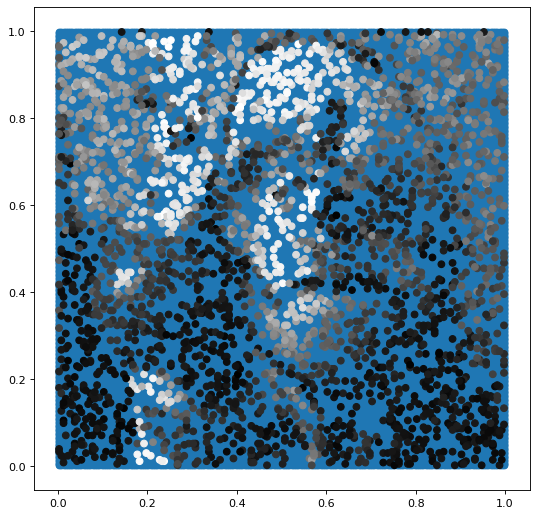

In [51]:
plt.gray()
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(Y[0,:], Y[1,:])
plt.scatter(Y[0,index], Y[1,index], c=C)
plt.show()

So we have a pretty good distribution of known/labelled data. They're not all clustered in one part of the grid, but scattered throughout which means we won't be extrapolating too much. 

To solve for our function $\bf{f(Y)}$, we create the adjacency matrix and weighted adjacency matrix below, and the graph Laplacian after. I didn't take advantage of the special grid structure of the data and just used the function from the first problem, so this step takes about 5-6 minutes.

In [6]:
# LONG step ~5-6 minutes
A, W = adjmatrix.getAdjacencyMatrixKNN(Y, k=4, sigma=1, is_data1=False)

In [7]:
# Create graph Lapalacian - abstraction of the Laplacian operator (2nd derivative in 1D)
# Allows to us to introduce a smoothness penalty for function into our optimization problem
diagonal = np.array(W.sum(0))[0]
D = scipy.sparse.diags(diagonal)
L = D - W

To solve for our $\bf{f}$, we can solve the following optimization problem using the 3200 labelled data points we have in $C$. Here $\bf{f}$ is a 64000 x 1 column vector.

\begin{gather}
\min_\bf{f} \frac{1}{2} \sum_{k=1}^{3200} (\bf{f}_{i(k)}-\bf{C}_k)^2+\frac{\alpha}{2}\bf{f^TLf} \\
\end{gather}

There's a way to rewrite this optimization into a form that's a common problem in numerical analysis. Since the left term is the sum of squared 
errors, there should be a way to rewrite this as the inner product of a vector with itself (2-norm squared). However, $\bf{f}$ is a 64000 x 1 column vector while $C$ is a 3200 x 1 column vector. 
So we need a matrix to transform $\bf{f}$ into the same dimension as $C$. 

We can introduce a matrix $P$ of dimension 3200 x 64000, where P[k, i(k)]=1 and 0 otherwise. Then the product $Pf$ will be a 3200 x 1 column vector, same as $C$. This way, our indices of the values we have in $C$ match up with the proper indices in the $\bf{f}$. 

\begin{gather}
\min_\bf{f} \frac{1}{2}\|Pf-C\|^2_2+\frac{\alpha}{2}f^TLf \\
\end{gather}

We now take advantage of some matrix calculus to find the derivative of this scalar with respect to the vector $\bf{f}$. First can look at the right side term. The scalar $\bf{f^TLf}$ is the quadratic form and its derivative is well known for symmetric matrices.

\begin{gather}
\frac{\partial \bf{\frac{\alpha}{2}f^TLf}}{\partial \bf{f}} = \frac{\alpha}{2}\bf{(L^T+L)f}=\alpha\bf{Lf}
\end{gather}

Bringing our attention to the left side term, we take the derivative of the squared 2-norm. 

\begin{gather}
\frac{\partial \frac{1}{2}\|\bf{Pf-C}\|^2_2}{\partial \bf{f}}=\frac{1}{2} 2\bf{\|Pf-C}\|_2 (\frac{\partial \bf{Pf - C}}{\partial f}) (\frac{\bf{Pf-C}}{\bf{\|Pf-C}\|_2})  = \bf{P^T(Pf-C)}
\end{gather}

Combining the two derivatives, we can now solve for $\bf{f}$ that minimizes our cost function

\begin{gather}
\bf{0}=P^TPf-P^TC+\alpha Lf \\ 
\bf{P^TC}=\bf{P^TPf}+ \alpha \bf{Lf} \\ 
\bf{P^TC}=(\bf{P^TP}+ \alpha \bf{L})f
\end{gather}

This boils down to the normal equations, but with an additional term added on to $\bf{P^TP}$. This optimization problem looks similar to ridge regression, which optimizes not just the sum of squares often found in ordinary least squares, 
but also an additional L2 penalty (a limit on the sum of squares of the coefficients)

Below we start by constructing the $\bf{P}$ matrix, and setting the $\alpha$ tuning parameter. 

In [9]:
# P is a (3200 x 64000) matrix where P[k,i(k)]=1 and 0 otherwise.
# k = range(3200)
m = C.shape[1]
n = Y.shape[1]
P = scipy.sparse.dok_matrix((m,n))
for k in range(C.shape[1]):
    P[k, index[0,k]] = 1
P = scipy.sparse.csc_matrix(P)

In [77]:
alpha = 0.5
b = scipy.sparse.csc_matrix.dot(P.T, C.T)
A = scipy.sparse.csc_matrix.dot(P.T, P) + alpha * L

Not sure how else to solve for this except with the normal equations (also not sure how to calculate the condition number of the $\bf{A=P^TP+\alpha L}$ matrix). Would use QR but has that additional term

In [78]:
f = scipy.sparse.linalg.spsolve(A,b)

We can visualize the function below on the 200 x 320 grid

<Figure size 432x288 with 0 Axes>

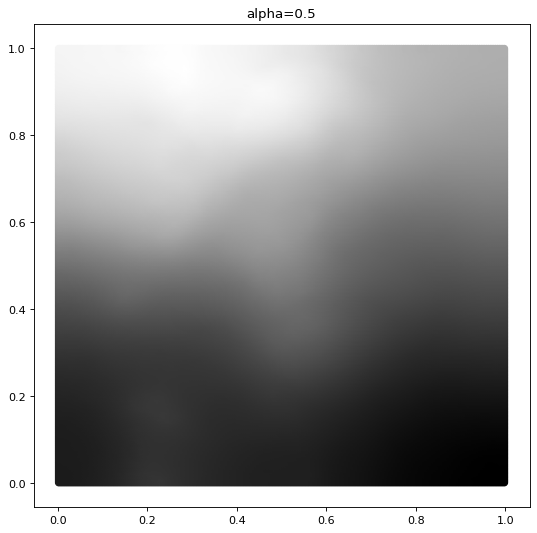

In [79]:
plt.gray()
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(Y[0,:], Y[1,:],c=f)
plt.title("alpha=0.5")
plt.show()

To get a better idea of how the function fits with the data, we can see how it looks with the 3200 points overlaying what we have. 

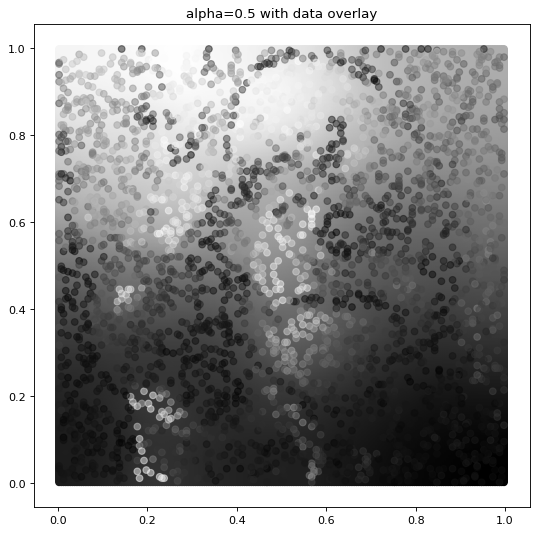

In [80]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(Y[0,:], Y[1,:],c=f)
plt.scatter(Y[0,index], Y[1,index],c=C, alpha=0.5)
plt.title("alpha=0.5 with data overlay")
plt.show()

We can see when we reduce the tuning parameter to near 0, the function looks much more like what the image should be when not completely smoothed over. It's a clown!

<Figure size 432x288 with 0 Axes>

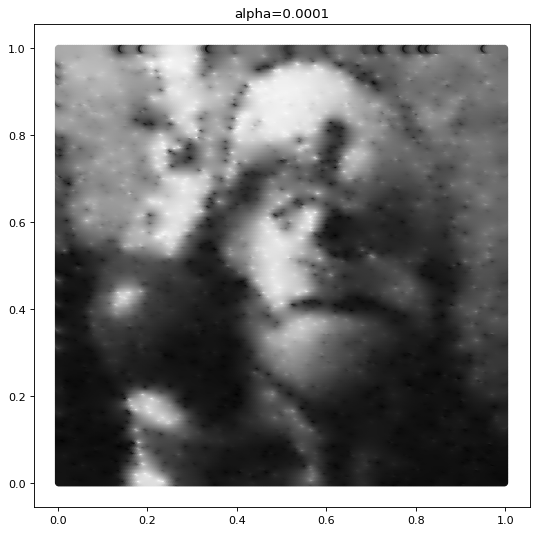

In [81]:
alpha=0.0001
A = scipy.sparse.csc_matrix.dot(P.T, P) + alpha * L
f = scipy.sparse.linalg.spsolve(A,b)
plt.gray()
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(Y[0,:], Y[1,:],c=f)
plt.title("alpha=0.0001")
plt.show()